## Import necessary libraries

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import os
import itertools
import datetime
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Data Preparation

Define directories for training and testing data

In [9]:
train_dir = 'Plant Diseases Dataset/train'
test_dir = 'Plant Diseases Dataset/valid'

Create image datasets for training and testing

In [10]:
train_data = keras.utils.image_dataset_from_directory(train_dir,
                                             image_size=(224, 224),
                                             label_mode='categorical',
                                             batch_size=32)

Found 70295 files belonging to 38 classes.


In [11]:
test_data = keras.utils.image_dataset_from_directory(test_dir,
                                         image_size=(224, 224),
                                         label_mode='categorical',
                                         batch_size=32)

Found 17572 files belonging to 38 classes.


Define class names based on the directory structure

In [12]:
class_names = train_data.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

# Step 2: Model Creation

Define the input image shape

In [21]:
image_shape = (224, 224, 3)

Create a base model (EfficientNetB0) for feature extraction

In [22]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

Create the main model by adding layers on top of the base model

In [23]:
inputs = layers.Input(shape=image_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D_layer')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
feature_model = tf.keras.Model(inputs, outputs, name='Crop_Diseases_Detection_Model')

Set some layers in the base model as trainable

In [24]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

Compile the model

In [25]:
feature_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [26]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, None, None, 24)       2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, None, None, 24)       96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, None, None, 144)      3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, None, None, 40)       5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, None, None, 40)       160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, None, None, 240)      9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, None, None, 80)       19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, None, None, 80)       320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, None, None, 480)      38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, None, None, 480)      1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, None, None, 80)       0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, None, None, 80)       0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, None, None, 480)      38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, None, None, 112)      0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, None, None, 672)      0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, None, None, 1152)     0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, None, None, 192)      0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, None, None, 1152)     0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, None, None, 1280)     0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
Total params: 4049571 (15.45 MB)
Trainable params: 1350960 (5.15 MB)
Non-trainable params: 2698611 (10.29 MB)
__________________________________________________________________________________________________


# Step 3: Model Training

Create a function to set up TensorBoard logging

In [27]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

Set up callbacks for training

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1, min_lr=1e-7)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss"
)

Train the model with early stopping, learning rate reduction, and checkpointing

In [29]:
epochs = 10
history = feature_model.fit(train_data, epochs=epochs,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data),
                            callbacks=[early_stopping, model_checkpoint, reduce_lr,
                                       create_tensorboard_callback('Crop Diseases Detection Model', 'EfficientNetB010')]
)

Saving TensorBoard log files to: Crop Diseases Detection Model/EfficientNetB010/20231117-202656
Epoch 1/10


2197/2197 [==============================] - 2489s 1s/step - loss: 0.2340 - accuracy: 0.9344 - val_loss: 0.0696 - val_accuracy: 0.9768 - lr: 1.0000e-04
Epoch 2/10
2197/2197 [==============================] - 2409s 1s/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0443 - val_accuracy: 0.9850 - lr: 1.0000e-04
Epoch 3/10
2197/2197 [==============================] - 2448s 1s/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0408 - val_accuracy: 0.9871 - lr: 1.0000e-04
Epoch 4/10
2197/2197 [==============================] - 2407s 1s/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0218 - val_accuracy: 0.9924 - lr: 1.0000e-04
Epoch 5/10
2197/2197 [==============================] - 2427s 1s/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0211 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 6/10
2197/2197 [==============================] - 2417s 1s/step - loss: 0.0060 - 

# Step 4: Model Evaluation

Load the best model checkpoint

In [30]:
feature_model.load_weights(checkpoint_path)

Evaluate the model on the test data

In [31]:
test_loss, test_accuracy = feature_model.evaluate(test_data)

550/550 [==============================] - 394s 717ms/step - loss: 0.0151 - accuracy: 0.9957


Print the evaluation results

In [32]:
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Loss: 0.02
Test Accuracy: 99.57%


# Step 5: Data Visualization and Model Metrics

Define a function to plot training history

In [33]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = history.epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Plot the training history

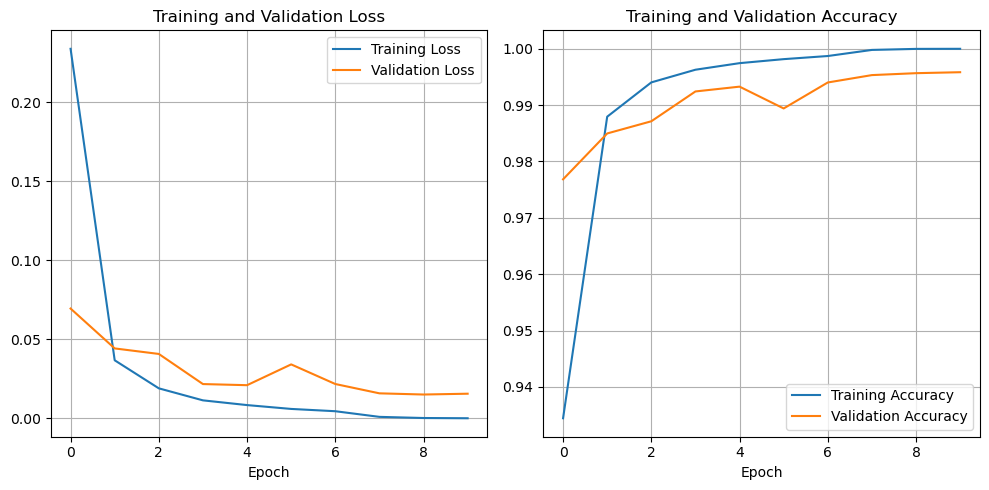

In [34]:
plot_history(history)

Calculate additional metrics for model evaluation

In [35]:
from sklearn.metrics import classification_report

def calculate_metrics(model, test_data):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(model.predict(images), axis=1))

    return y_true, y_pred

In [36]:
y_true, y_pred = calculate_metrics(feature_model, test_data)

1/1 [==============================] - 1s 697ms/step


1/1 [==============================] - 1s 705ms/step


1/1 [==============================] - 1s 692ms/step


1/1 [==============================] - 2s 2s/step


Print classification report

In [37]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.98      0.98       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.98      0.99      0.

Compute the confusion matrix

In [38]:
confusion = confusion_matrix(y_true, y_pred)

Plot the confusion matrix

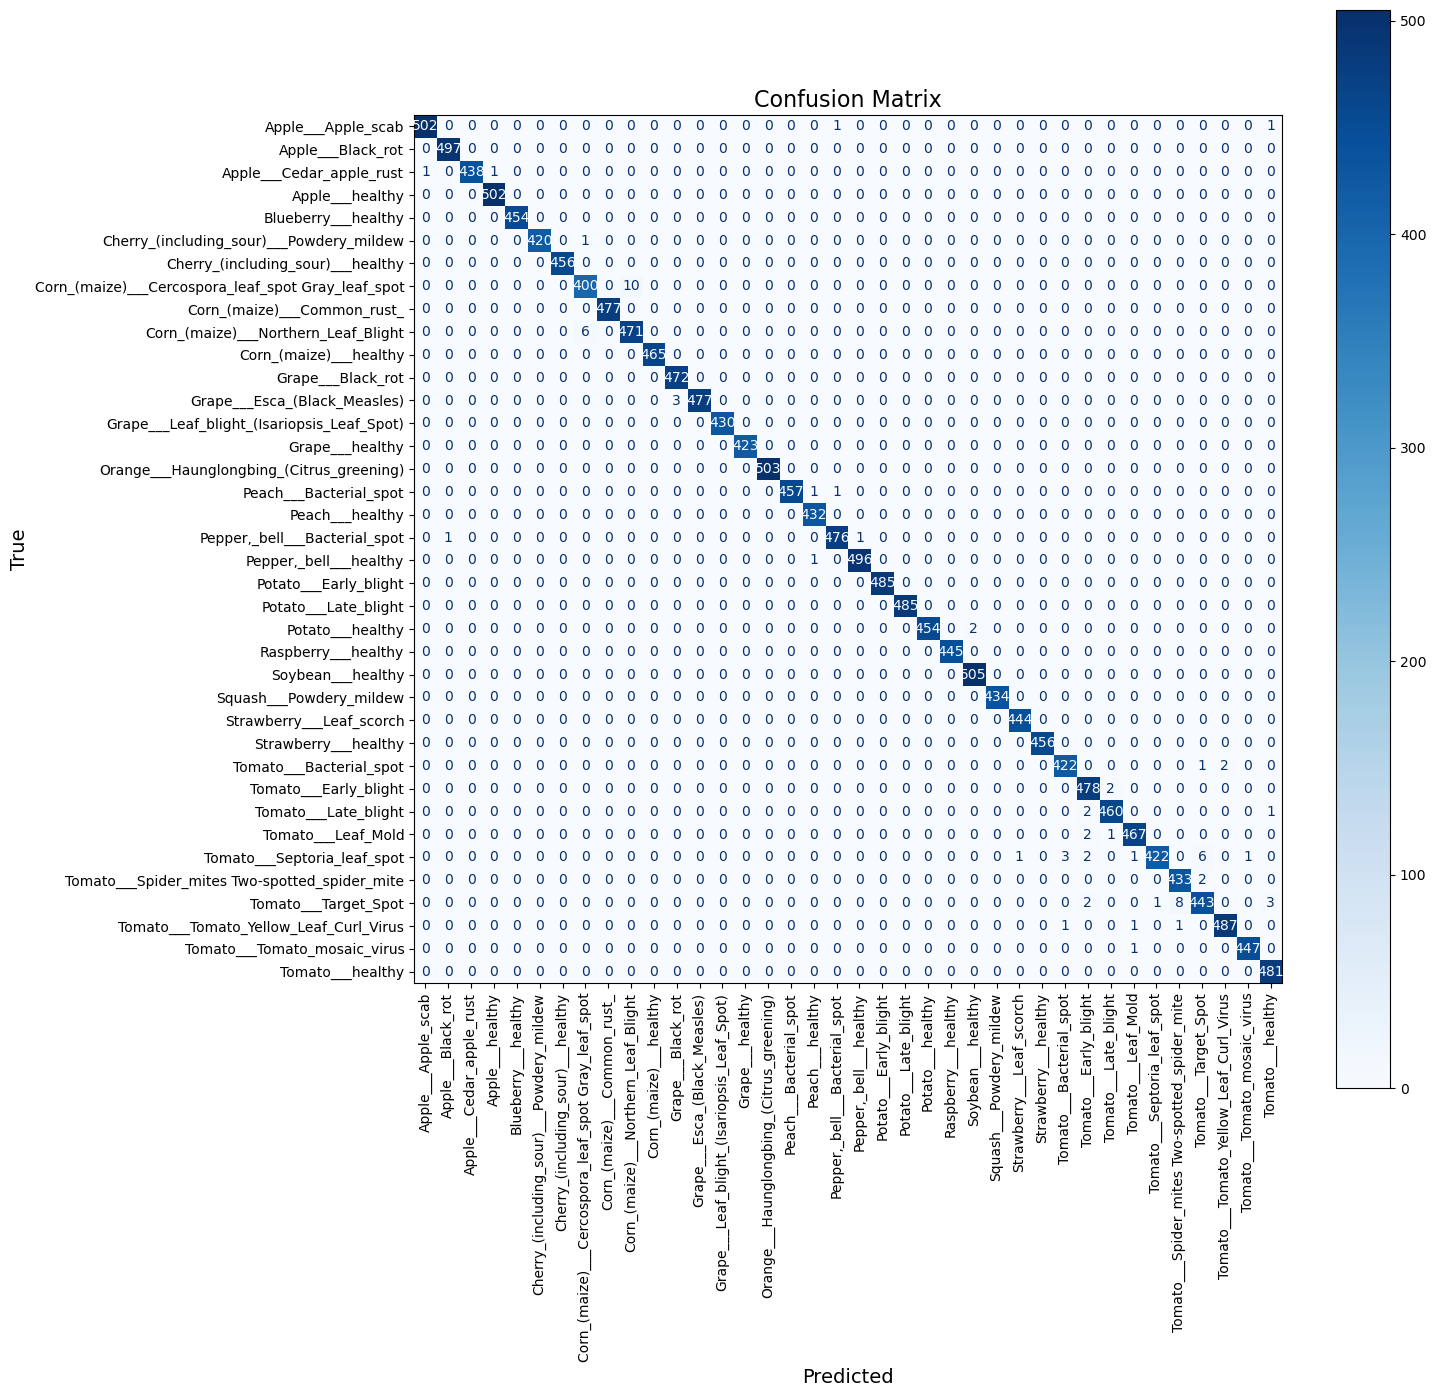

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(confusion, class_names):
    num_classes = len(class_names)
    fig, ax = plt.subplots(figsize=(14, 14))

    # Convert the confusion matrix values to integers
    confusion = confusion.astype(int)

    disp = ConfusionMatrixDisplay(confusion, display_labels=class_names)
    disp = disp.plot(cmap=plt.get_cmap("Blues"), values_format="d", ax=ax)

    # Rotate y-axis class names to be straight at 90 degrees
    ax.set_yticklabels(class_names, rotation=0, fontsize=10)

    # Set the tick labels and fontsize for x-axis
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=10)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.show()

plot_confusion_matrix(confusion, class_names)

# Step 6: Save Model

In [40]:
tf.saved_model.save(feature_model, 'Crop Diseases Detection Model')

INFO:tensorflow:Assets written to: Crop Diseases Detection Model\assets


INFO:tensorflow:Assets written to: Crop Diseases Detection Model\assets


In [41]:
h5_model_path = 'Crop Diseases Detection Model.h5'
feature_model.save(h5_model_path)

C:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
tflite_model_path = 'Crop Diseases Detection Model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(feature_model)
tflite_model = converter.convert()

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\PMLS\AppData\Local\Temp\tmpimbna_em\assets


INFO:tensorflow:Assets written to: C:\Users\PMLS\AppData\Local\Temp\tmpimbna_em\assets


# Step 7: Image Prediction

Define a function to load and preprocess an image

In [43]:
def load_prep(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size=(224, 224))
    return img

Load and preprocess an image, and make a prediction

Text(0.5, 0.98, '(224, 224, 3)')

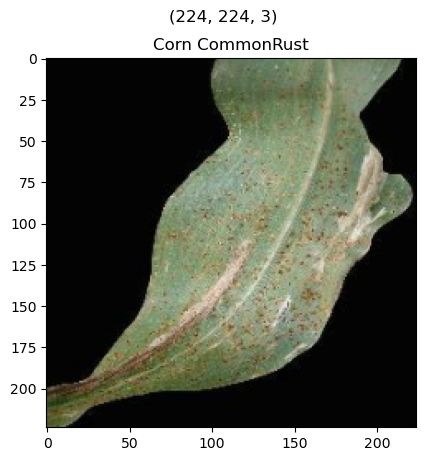

In [44]:
image = load_prep('test/CornCommonRust1.jpg')
plt.imshow(image / 255.)
plt.title('Corn CommonRust')
plt.suptitle(image.shape)

In [45]:
pred = feature_model.predict(tf.expand_dims(image, axis=0))
predicted_class = class_names[pred.argmax()]
predicted_prob = pred.max()

1/1 [==============================] - 0s 227ms/step


Print the predicted class and probability

In [46]:
print(f'Predicted Class: {predicted_class}')
print(f'Predicted Probability: {predicted_prob * 100:.2f}%')

Predicted Class: Corn_(maize)___Common_rust_
Predicted Probability: 100.00%


Define a function to randomly select an image from the test data and make a prediction


In [47]:
def random_image_predict(model, test_dir=test_dir, class_names=class_names, rand_class=True, cls_name=None):
    if rand_class:
        ran_cls = random.randint(0, len(class_names) - 1)
        cls = class_names[ran_cls]
        
        # Get a list of all files in the class directory
        class_dir = os.path.join(test_dir, cls)
        files = os.listdir(class_dir)

        # Choose a random file from the list
        random_file = random.choice(files)

        # Create the full path to the random file
        ran_path = os.path.join(class_dir, random_file)
    else:
        cls = class_names[cls_name]
        
        # Get a list of all files in the class directory
        class_dir = os.path.join(test_dir, cls)
        files = os.listdir(class_dir)

        # Choose a random file from the list
        random_file = random.choice(files)

        # Create the full path to the random file
        ran_path = os.path.join(class_dir, random_file)

    prep_img = load_prep(ran_path)

    pred = model.predict(tf.expand_dims(prep_img, axis=0))
    pred_cls = class_names[pred[0].argmax()]
    pred_percent = pred[0][pred[0].argmax()] * 100
    plt.imshow(prep_img / 255.)
    if pred_cls == cls:
        c = 'g'
    else:
        c = 'r'
    plt.title(f'Actual: {cls}\nPredicted: {pred_cls}\nProbability: {pred_percent:.2f}%', color=c, fontdict={'fontsize': 10})
    plt.axis(False)

Display 9 randomly predicted images from the test data

1/1 [==============================] - 0s 63ms/step


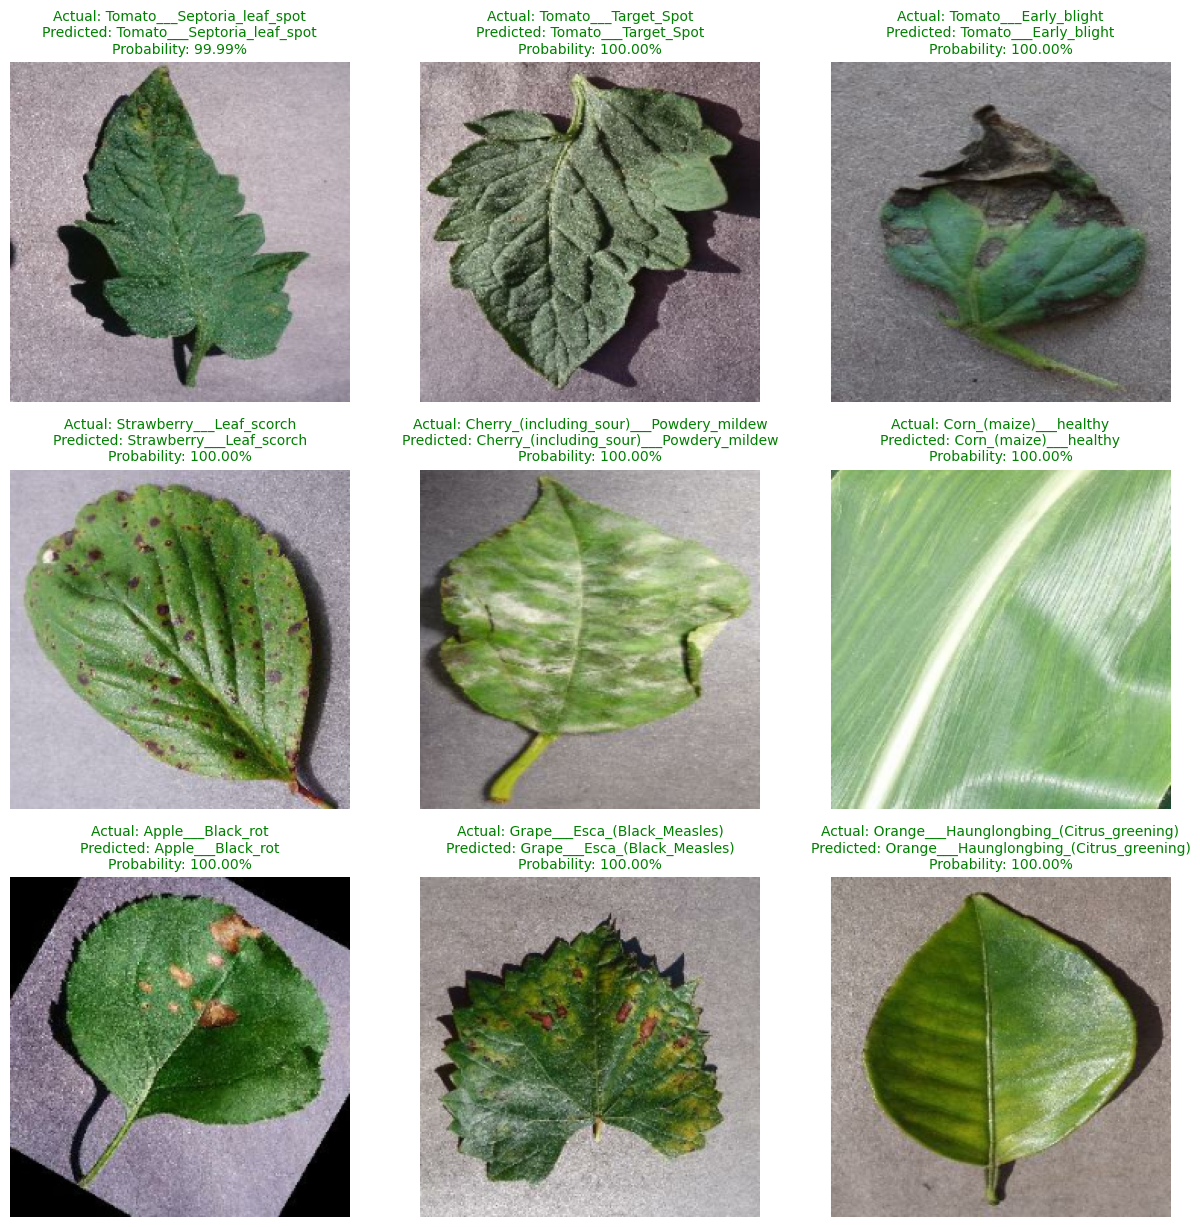

In [48]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    random_image_predict(feature_model, test_dir)

Define a directory containing images for prediction

1/1 [==============================] - 0s 69ms/step


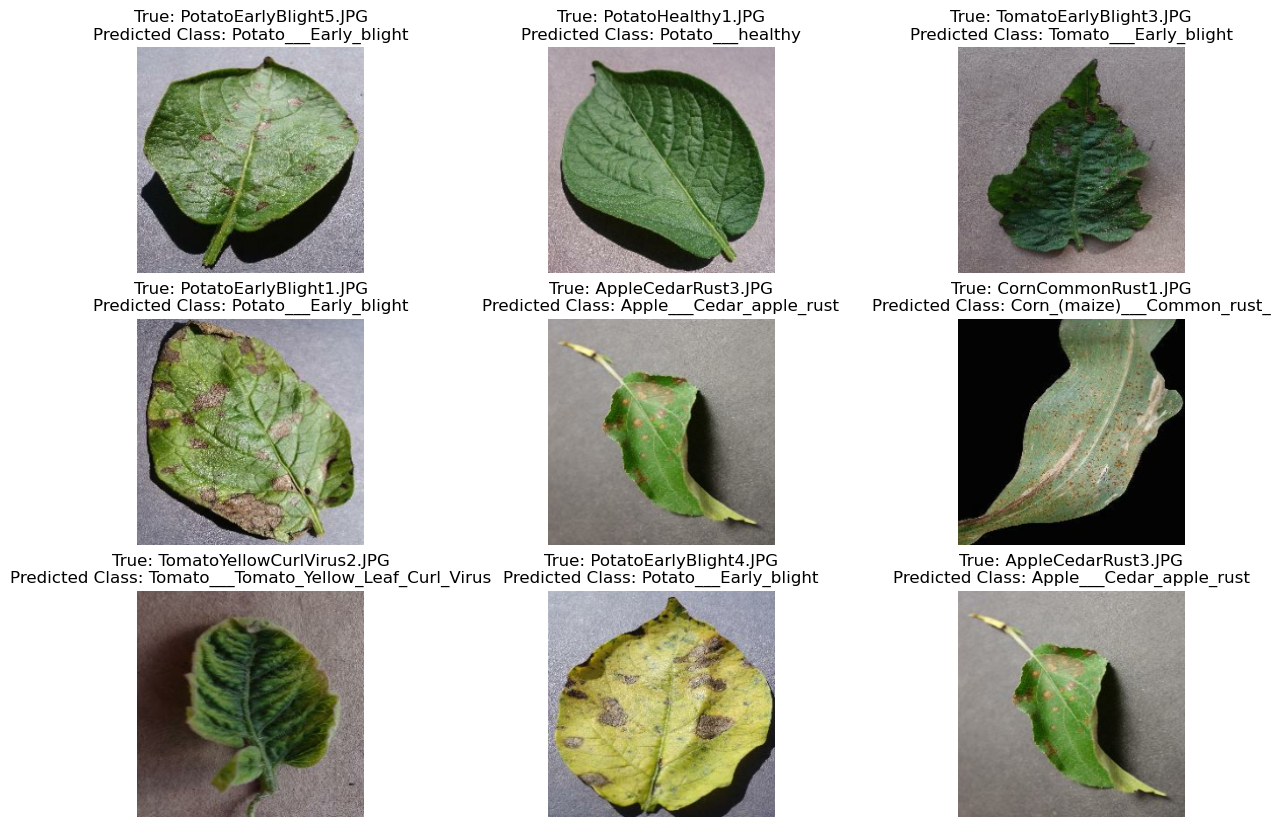

In [49]:
data_dir = 'test'
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    rn = random.choice(os.listdir(data_dir))
    image_path = os.path.join(data_dir, rn)
    img = load_prep(image_path)
    pred = feature_model.predict(tf.expand_dims(img, axis=0))
    pred_name = class_names[pred.argmax()]
    plt.imshow(img / 255.)
    plt.title(f'True: {rn}\nPredicted Class: {pred_name}')
    plt.axis(False)

Define a function to predict an image from a given path

In [50]:
def predict_img(img_path, model=feature_model):
    img = load_prep(img_path)
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred_name = class_names[pred.argmax()]
    plt.imshow(img / 255.)
    plt.title(f'Predicted Class: {pred_name}')
    plt.axis(False)

# Step 8: Image Prediction for load Crop Diseases Detection model

In [51]:
loaded_model = tf.saved_model.load('Crop Diseases Detection Model')

Define a function to load and preprocess an image

In [52]:
def load_prep(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size=(224, 224))
    return img

Define the directory containing the images for prediction

In [53]:
test_directory = 'test'

Get a list of image file paths

In [54]:
image_paths = [os.path.join(test_directory, img) for img in os.listdir(test_directory)]

Make predictions on each image

In [55]:
predictions = []

for img_path in image_paths:
    img = load_prep(img_path)
    img = tf.expand_dims(img, axis=0)

    # Run inference using the loaded model
    prediction = loaded_model(img)
    predicted_class = class_names[np.argmax(prediction)]
    predictions.append((img_path, predicted_class))

Display the predictions

In [56]:
for img_path, predicted_class in predictions:
    print(f'Image: {os.path.basename(img_path)} - Predicted Class: {predicted_class}')

Image: AppleCedarRust1.JPG - Predicted Class: Apple___Cedar_apple_rust
Image: AppleCedarRust2.JPG - Predicted Class: Apple___Cedar_apple_rust
Image: AppleCedarRust3.JPG - Predicted Class: Apple___Cedar_apple_rust
Image: AppleCedarRust4.JPG - Predicted Class: Apple___Cedar_apple_rust
Image: AppleScab1.JPG - Predicted Class: Apple___Apple_scab
Image: AppleScab2.JPG - Predicted Class: Apple___Apple_scab
Image: AppleScab3.JPG - Predicted Class: Apple___Apple_scab
Image: CornCommonRust1.JPG - Predicted Class: Corn_(maize)___Common_rust_
Image: CornCommonRust2.JPG - Predicted Class: Corn_(maize)___Common_rust_
Image: CornCommonRust3.JPG - Predicted Class: Corn_(maize)___Common_rust_
Image: PotatoEarlyBlight1.JPG - Predicted Class: Potato___Early_blight
Image: PotatoEarlyBlight2.JPG - Predicted Class: Potato___Early_blight
Image: PotatoEarlyBlight3.JPG - Predicted Class: Potato___Early_blight
Image: PotatoEarlyBlight4.JPG - Predicted Class: Potato___Early_blight
Image: PotatoEarlyBlight5.JPG 